## Play with left and right eye data
### Reference
1. How to Synchroniza Time Series Datasets in Python. https://towardsdatascience.com/how-to-synchronize-time-series-datasets-in-python-f2ae51bee212.
2. Specifications about Pupil Labs's Pupil Core. https://docs.pupil-labs.com/core/best-practices/.

### Implemetation

In [1]:
import pandas as pd
import numpy as np
import math, os
from numba import jit
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw

def plotter(ax, data1, data2, param_dict):
    out = ax.plot(data1, data2, **param_dict)
    return out

According to Pupil Labs's specification, since our experiments are conducting studies in the mobile setting, we'd better use 3D pipeline, i.e., use data generated by 3D models.

In [2]:
# Read left and right eyes' data.
left_eye_filepath = '../Data/RawData/08-09-12-20-highlux-ONEBACK/left2D_81Hz.csv'
right_eye_filepath = '../Data/RawData/08-09-12-20-highlux-ONEBACK/right2D_78Hz.csv'

In [3]:
# Tag labels
SAMPLING_RATE_LEFT = int((left_eye_filepath.split('_')[-1]).split('Hz')[0])
data_left = pd.read_csv(left_eye_filepath)

SAMPLING_RATE_RIGHT = int((right_eye_filepath.split('_')[-1]).split('Hz')[0])
data_right = pd.read_csv(right_eye_filepath)

In [4]:
df_left = data_left[['Timestamp','Confidence','Diameter','Event']].copy()
df_right = data_right[['Timestamp','Confidence','Diameter','Event']].copy()

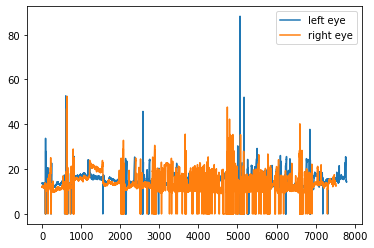

In [5]:
# Plot to get a brief look over the 2 sets data and the gap between them.
fig, ax = plt.subplots()
df_left['Diameter'].plot(ax=ax)
df_right['Diameter'].plot(ax=ax)
ax.legend(["left eye", "right eye"])

In [6]:
# Calculate two signals' correlation as a reference.
# correlation = r2_score(df_left['Diameter'], df_right['Diameter'])

### Synchronize with dynamic time warper method
While this method does not rely on the timestamp, soly on data values.

In [7]:
# Calculate for warping.
distance, path = fastdtw(df_left['Diameter'], df_right['Diameter'], dist=euclidean)

In [8]:
len(df_left['Diameter']), len(df_right['Diameter']), len(path)

(7792, 7521, 13606)

In [9]:
result = []
for i in range(0, len(path)):
    result.append([path[i][0],
                   df_left['Diameter'].iloc[path[i][0]],
                   df_right['Diameter'].iloc[path[i][1]]])
df_sync = pd.DataFrame(data=result,columns=['Index','Left Diameter','Right Diameter']).dropna()
df_sync = df_sync.drop_duplicates(subset=['Index'])
df_sync = df_sync.reset_index(drop=True)
df_sync

,Index,Left Diameter,Right Diameter
0,0,13.864768,12.039151
1,1,13.864768,12.139669
2,2,13.676766,12.217205
3,3,13.557002,12.434216
4,4,13.544827,12.222660
...,...,...,...
7787,7787,14.553446,14.453408
7788,7788,14.543165,14.201611
7789,7789,14.402097,14.459430
7790,7790,14.568738,14.479804


In [10]:
correlation = r2_score(df_sync['Left Diameter'], df_sync['Right Diameter'])
correlation

0.10626617618457279

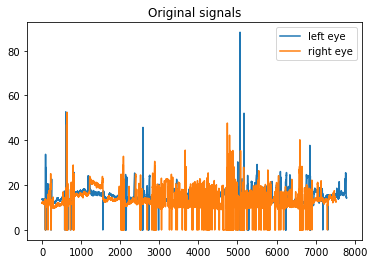

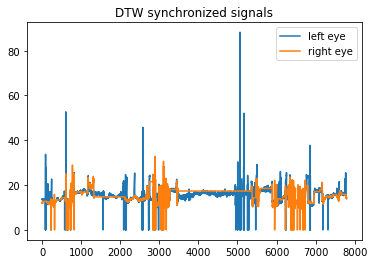

In [11]:
# Plot to get a brief look over the 2 sets data and the gap between them.
fig_orig, ax_orig = plt.subplots()
df_left['Diameter'].plot(ax=ax_orig)
df_right['Diameter'].plot(ax=ax_orig, title = 'Original signals')
ax_orig.legend(["left eye", "right eye"])

# Plot to get a brief look over the 2 sets of synchronized data and the gap between them.
fig_sync, ax_sync = plt.subplots()
df_sync['Left Diameter'].plot(ax=ax_sync)
df_sync['Right Diameter'].plot(ax=ax_sync, title = 'DTW synchronized signals')
ax_sync.legend(["left eye", "right eye"])

Seems a lot of data are missing compared to the original signals. Maybe change other methods.

### Synchronize according to given timestamps
There is a column called "World Index", I will try directly synchornizing 2 eyes' data using this metric. https://docs.pupil-labs.com/core/terminology/

I planned to use 3D model's data due to studies' mobility, however 2 eyes' data did not show any correlation, cannot be synchronized at all, hence I used 2D model's data.